In [1]:
# Libraries

import numpy
import os
import shutil
import warnings

In [2]:
# Code

from src.data.analysis import gene_annotation as data_annotation
from src.data.analysis import gene_assembly   as data_assembly
from src.data.analysis import tissue_metadata as data_metadata
from src.data.analysis import tissue_tpm      as data_tpm
from src.io            import loader          as data_loader
from src.io            import writer          as data_writer

# 1. Setup

In [3]:
# Setup some directory paths

OUT_SUBFOLDER = 'nbp01-analysis'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA   = os.path.join(OUT, 'data',   OUT_SUBFOLDER)
OUT_PLOT   = os.path.join(OUT, 'plot',   OUT_SUBFOLDER)
OUT_REPORT = os.path.join(OUT, 'report', OUT_SUBFOLDER)
RES_PLANT  = os.path.join(RES, 'plant',  RES_SUBFOLDER)

MODIFICATION_CHECK = os.path.join(OUT_REPORT, 'modification-check.log')
MODIFICATION_SYNC  = os.path.join(OUT_REPORT, 'modification-sync.log')

shutil.rmtree(OUT_DATA,   ignore_errors = True)
shutil.rmtree(OUT_PLOT,   ignore_errors = True)
shutil.rmtree(OUT_REPORT, ignore_errors = True)

os.makedirs(OUT_DATA,   exist_ok = True)
os.makedirs(OUT_PLOT,   exist_ok = True)
os.makedirs(OUT_REPORT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Load and clean (remove non-relevant columns, rename columns to same format, etc..)

data = data_loader.load_resources(
	directory = RES_PLANT,
	plant     = 'arabidopsis-r36',
	clean     = True
)

gene_annotation = data['gene_annotation']
gene_assembly   = data['gene_assembly']
tissue_metadata = data['tissue_metadata']
tissue_tpm      = data['tissue_tpm']

# 2. Gene Annotation

In [5]:
# Show the first few gene annotations

data_annotation.show(gene_annotation)

Number of rows : 784467
Number of cols : 8


,Seq,Strand,Type,Gene,mRNA,Start,End,Length
1,1,+,Gene,AT1G01010,NaN,3631,5899,2269
2,1,+,mRNA,AT1G01010,AT1G01010.1,3631,5899,2269
3,1,+,UTR5,AT1G01010,AT1G01010.1,3631,3759,129
4,1,+,Exon,AT1G01010,AT1G01010.1,3631,3913,283
5,1,+,CDS,AT1G01010,AT1G01010.1,3760,3913,154


In [6]:
# Inspect gene annotation columns, and dispay the number of unique values (as well as the first few values)

data_annotation.inspect_columns(
	data    = gene_annotation,
	columns = None
)

Unique values per column :

 - Seq     : [      7] 1 2 3 4 5 ...
 - Strand  : [      2] + -
 - Type    : [      6] Gene mRNA UTR5 Exon CDS ...
 - Gene    : [ 32,833] AT1G01010 AT1G01020 AT1G03987 AT1G01030 AT1G01040 ...
 - mRNA    : [ 54,014] nan AT1G01010.1 AT1G01020.6 AT1G01020.2 AT1G01020.3 ...
 - Start   : [227,534] 3631 3760 3996 4486 4706 ...
 - End     : [227,530] 5899 3759 3913 4276 4605 ...
 - Length  : [  7,298] 2269 129 283 154 281 ...


,Seq,Strand,Type,Gene,mRNA,Start,End,Length
Datatype,object,object,object,object,object,int32,int32,int32
Null,0,0,0,0,31435,0,0,0
Unique,7,2,6,32833,54014,227534,227530,7298


In [7]:
# Display a full gene with all its regions

data_annotation.show(
	data  = gene_annotation,
	query = 'AT1G01010.1',
	rows  = None
)

Number of rows : 15
Number of cols : 8


,Seq,Strand,Type,Gene,mRNA,Start,End,Length
2,1,+,mRNA,AT1G01010,AT1G01010.1,3631,5899,2269
3,1,+,UTR5,AT1G01010,AT1G01010.1,3631,3759,129
4,1,+,Exon,AT1G01010,AT1G01010.1,3631,3913,283
5,1,+,CDS,AT1G01010,AT1G01010.1,3760,3913,154
6,1,+,Exon,AT1G01010,AT1G01010.1,3996,4276,281
7,1,+,CDS,AT1G01010,AT1G01010.1,3996,4276,281
8,1,+,Exon,AT1G01010,AT1G01010.1,4486,4605,120
9,1,+,CDS,AT1G01010,AT1G01010.1,4486,4605,120
10,1,+,Exon,AT1G01010,AT1G01010.1,4706,5095,390
11,1,+,CDS,AT1G01010,AT1G01010.1,4706,5095,390


In [8]:
# Group regions by mRNA and drop those that are not real mRNA groups

gene_annotation['Group'] = gene_annotation.groupby('mRNA').ngroup()
gene_annotation['Group'] = gene_annotation['Group'].apply(lambda x : int(1 + x) if not numpy.isnan(x) else 0)

groups = list()

for group, dataframe in gene_annotation.groupby('Group') :
	if sum(dataframe['Type'] == 'mRNA') == 0 and group > 0 :
		groups.append(group)

groups = gene_annotation['Group'].isin(groups)

gene_filter = gene_annotation[groups]
gene_filter = gene_filter['mRNA'].unique()

print('Dropped [{}] regions or [{}] mRNA, due to not being a valid mRNA'.format(sum(groups), len(gene_filter)))

gene_annotation = gene_annotation[~groups]

Dropped [7947] regions or [5692] mRNA, due to not being a valid mRNA


In [9]:
# Log the changes to the modification file

with open(MODIFICATION_CHECK, mode = 'a') as report :
	if len(gene_filter) > 0 :
		report.write('# Droping <mRNA> in <gene-annotation>\n')
		report.write('\n')

		for item in gene_filter :
			report.write(f'Removed mRNA <{item:12s}> from <gene-annotation> due to <not being a valid mRNA>\n')

		report.write('\n')

In [10]:
# Show the first few gene annotations

data_annotation.show(gene_annotation)

Number of rows : 776520
Number of cols : 9


,Seq,Strand,Type,Gene,mRNA,Start,End,Length,Group
1,1,+,Gene,AT1G01010,NaN,3631,5899,2269,0
2,1,+,mRNA,AT1G01010,AT1G01010.1,3631,5899,2269,1
3,1,+,UTR5,AT1G01010,AT1G01010.1,3631,3759,129,1
4,1,+,Exon,AT1G01010,AT1G01010.1,3631,3913,283,1
5,1,+,CDS,AT1G01010,AT1G01010.1,3760,3913,154,1


In [11]:
# Drop Mt and Pt sequences if needed

mt = gene_annotation[(gene_annotation['Seq'] == 'Mt') & (gene_annotation['Type'] == 'mRNA')]
pt = gene_annotation[(gene_annotation['Seq'] == 'Pt') & (gene_annotation['Type'] == 'mRNA')]

print(f'Number of mRNA regions in Mt sequence : ' + '{}'.format(len(mt)))
print(f'Number of mRNA regions in Pt sequence : ' + '{}'.format(len(pt)))

# gene_annotation = gene_annotation[~gene_annotation['Seq'].isin(['Mt', 'Pt'])]

Number of mRNA regions in Mt sequence : 120
Number of mRNA regions in Pt sequence : 88


In [12]:
# Display region type count per gene

data_annotation.type_distribution(
	data    = gene_annotation,
	groupby = 'Group',
	regions = ['mRNA', 'Exon', 'UTR5', 'CDS', 'UTR3']
)

,Count,0,1,2,3,4,5+
mRNA,48321,0,48321,0,0,0,0
Exon,306005,0,6250,6577,5441,4610,25443
UTR5,56384,5606,31233,9476,1874,99,33
CDS,286067,0,8093,6686,5451,4639,23452
UTR3,48308,5999,37615,3612,1011,49,35


In [13]:
# Display the region length statistics per each region

data_annotation.length_statistics(
	data = gene_annotation
)

,Count,Mean,Std,Min,25%,50%,75%,Max
Gene,31435.00,2155.92,1662.19,3.00,992.00,1884.00,2867.00,27265.00
mRNA,48321.00,2653.60,1760.88,3.00,1573.00,2313.00,3300.00,27265.00
UTR5,56384.00,184.56,190.92,1.00,62.00,135.00,244.00,3680.00
Exon,306005.00,282.32,360.80,1.00,90.00,153.00,330.00,7761.00
CDS,286067.00,218.99,301.27,1.00,81.00,126.00,224.00,7761.00
UTR3,48308.00,276.15,205.00,1.00,162.00,241.00,340.00,4001.00


In [14]:
# Group same region types within the same mrna

dataframe = data_annotation.group_regions(
	data    = gene_annotation,
	groupby = 'mRNA',
	regions = ['mRNA', 'Exon', 'UTR5', 'CDS', 'UTR3']
)

In [15]:
# Display the region length statistics per each region (grouped regions)

data_annotation.length_statistics(
	data = dataframe
)

,Count,Mean,Std,Min,25%,50%,75%,Max
mRNA,48321.00,2653.60,1760.88,3.00,1573.00,2313.00,3300.00,27265.00
Exon,48321.00,1787.86,1079.91,3.00,1094.00,1595.00,2211.00,16593.00
UTR5,48321.00,215.36,227.21,0.00,70.00,160.00,289.00,3972.00
CDS,48321.00,1296.45,982.12,3.00,657.00,1083.00,1626.00,16203.00
UTR3,48321.00,276.08,243.55,0.00,147.00,238.00,346.00,4144.00


# 3. Gene Assembly

In [16]:
# Display the length and short nucleotide sequences for each chromosome

data_assembly.show(
	data = gene_assembly,
	head = 25,
	tail = 25
)

Sequence [1 ] with length [30,427,671] : CCCTAAACCCTAAACCCTAAACCCT ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [2 ] with length [19,698,289] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [3 ] with length [23,459,830] : NNNNNNNNNNNNNNNNNNNNNNNNN ... ACCCTAAACCCTAAACCCTAAACCC
Sequence [4 ] with length [18,585,056] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AAGGGTTTAGGGTTTAGGGTTTAGG
Sequence [5 ] with length [26,975,502] : TATACCATGTACCCTCAACCTTAAA ... GTTTAGGATTTAGGGTTTTTAGATC
Sequence [Mt] with length [   366,924] : GGATCCGTTCGAAACAGGTTAGCCT ... TCGCAGAATGGAAACAAACCGGATT
Sequence [Pt] with length [   154,478] : ATGGGCGAACGACGGGAATTGAACC ... TCATAATAACTTGGTCCCGGGCATC


In [17]:
# Display the nucleotide frequency withing each chromosome

data_assembly.show_nucleotide_frequency(
	data     = gene_assembly,
	relative = False
)

,A,T,C,G,N,W,Y,M,K,R,S,D
1,9709674,9697113,5435374,5421151,163958,124,82,76,53,36,30,0
2,6315641,6316348,3542973,3520766,2506,18,12,5,10,7,3,0
3,7484757,7448059,4258333,4262704,5966,2,2,2,0,4,1,0
4,5940546,5914038,3371349,3356091,3030,0,0,1,0,0,0,1
5,8621974,8652238,4832253,4858759,10278,0,0,0,0,0,0,0
Mt,102464,100190,82661,81609,0,0,0,0,0,0,0,0
Pt,48546,49866,28496,27570,0,0,0,0,0,0,0,0
Total,38223602,38177852,21551439,21528650,185738,144,96,84,63,47,34,1


# 4. Tissue Metadata

In [18]:
# Display the first few annotated samples

data_metadata.show(tissue_metadata)

Number of rows : 4139
Number of cols : 8


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
0,DRR273449,DRP006986,yes,no,mature,seedling,mature_seedling,control
1,DRR273450,DRP006986,yes,no,mature,seedling,mature_seedling,control
2,DRR273451,DRP006986,yes,no,mature,seedling,mature_seedling,control
3,DRR273452,DRP006986,no,no,mature,seedling,mature_seedling,environmental
4,DRR273453,DRP006986,no,no,mature,seedling,mature_seedling,environmental


In [19]:
# Inspect sample annotation columns, and dispay the number of unique values (as well as the first few values)

data_metadata.inspect_columns(
	data    = tissue_metadata,
	columns = None
)

Unique values per column :

 - Sample       : [4,139] DRR273449 DRR273450 DRR273451 DRR273452 DRR273453 ...
 - Study        : [  277] DRP006986 DRP004882 DRP005301 DRP005881 DRP005877 ...
 - Control      : [    2] yes no
 - Senescence   : [    2] no yes
 - Age          : [    5] mature young missing senescence seed
 - Tissue       : [    8] seedling seed leaf root flower ...
 - Group        : [   19] mature_seedling young_seedling young_seed missing_seedling mature_leaf ...
 - Perturbation : [    8] control environmental unstressed chemical mutant ...


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
Datatype,object,object,object,object,object,object,object,object
Null,0,0,0,0,0,0,0,0
Unique,4139,277,2,2,5,8,19,8


# 5. Tissue TPM

In [20]:
# Display the first few tpm values

data_tpm.show(tissue_tpm)

Number of rows : 48359
Number of cols : 4147


,mRNA,DRR090011,DRR090012,DRR090013,DRR090014,DRR090015,DRR090016,DRR090017,DRR090018,DRR090019
0,AT1G01010.1,17.95,19.72,30.89,25.35,29.91,17.37,25.47,32.01,33.05
1,AT1G01020.1,2.14,0.00,0.50,1.46,2.08,0.00,1.56,0.63,0.06
2,AT1G01020.2,11.19,8.39,10.54,12.32,9.22,8.17,8.46,9.68,10.08
3,AT1G01020.3,0.00,0.00,2.56,0.00,0.01,2.02,1.93,0.00,0.00
4,AT1G01020.4,3.15,3.58,0.00,1.40,0.57,1.42,1.61,2.90,2.89


In [21]:
# Print the global tpm statistics

matrix = tissue_tpm.iloc[:, 1:].to_numpy()
string = '{:9,.1f}'

print(f'   Max TPM : ' + string.format(numpy.max(matrix)))
print(f'  Mean TPM : ' + string.format(numpy.mean(matrix)))
print(f'Median TPM : ' + string.format(numpy.median(matrix)))
print(f'   Min TPM : ' + string.format(numpy.min(matrix)))

   Max TPM : 586,287.0
  Mean TPM :      20.7
Median TPM :       1.1
   Min TPM :       0.0


# 6. Filtering

In [22]:
# Filter samples that are problematic globally

dataframe, sample_filter = data_tpm.filter_samples(
	data    = tissue_tpm,
	cutoff  = {
		'max' : 0.0,
		'sum' : 0.0,
		'std' : 0.0,
		'px0' : [
			0.0,
			0.0
		]
	}
)

Problematic items found : 0


In [23]:
# Display an example of a problematic sample (if detected)

if len(sample_filter) > 0 :
	item = list(sample_filter.keys())[0]
	data = dataframe[item].to_numpy()

	print(f'Sample <{item}> has a sum expression : {data.sum():9.4f}')
	print(f'Sample <{item}> has a max expression : {data.max():9.4f}')
	print(f'Sample <{item}> has a min expression : {data.min():9.4f}')

In [24]:
# Filter genes that are problematic globally

dataframe, gene_filter = data_tpm.filter_genes(
	data    = tissue_tpm,
	cutoff  = {
		'max' : 0.0,
		'sum' : 0.0,
		'std' : 0.0,
		'px0' : [
			0.0,
			0.0
		]
	}
)

Problematic items found : 20 --> AT1G24475.1 ; var(TPM) = 0.0


In [25]:
# Display an example of a problematic gene (if detected)

if len(gene_filter) > 0 :
	item = list(gene_filter.keys())[0]
	data = dataframe[item].to_numpy()

	print(f'Gene <{item}> has a sum expression : {data.sum():9.4f}')
	print(f'Gene <{item}> has a max expression : {data.max():9.4f}')
	print(f'Gene <{item}> has a min expression : {data.min():9.4f}')

Gene <AT1G24475.1> has a sum expression :    0.0000
Gene <AT1G24475.1> has a max expression :    0.0000
Gene <AT1G24475.1> has a min expression :    0.0000


In [26]:
# Remove the problematic samples and genes from the tpm table

if len(sample_filter) > 0 :
	array = list(sample_filter.keys())
	tissue_tpm = tissue_tpm.drop(columns = array)

if len(gene_filter) > 0 :
	array = list(gene_filter.keys())
	tissue_tpm = tissue_tpm[~tissue_tpm['mRNA'].isin(array)]

In [27]:
# Log the changes to the modification file

with open(MODIFICATION_CHECK, mode = 'a') as report :
	if len(sample_filter) > 0 :
		report.write('# Cleaning <Sample> in <tissue-tpm>\n')
		report.write('\n')

		for item, reason in sample_filter.items() :
			report.write(f'Removed Sample <{item:11s}> from <tissue-tpm> due to <{reason}>\n')

		report.write('\n')

	if len(gene_filter) > 0 :
		report.write('# Cleaning <mRNA> in <tissue-tpm>\n')
		report.write('\n')

		for item, reason in gene_filter.items() :
			report.write(f'Removed mRNA <{item:12s}> from <tissue-tpm> due to <{reason}>\n')

		report.write('\n')

In [28]:
# Check for sample matching between tpm and metadata tables

x = set(tissue_metadata['Sample'].dropna())
y = set(tissue_tpm.columns[1:].dropna())

sample_i = list(x.intersection(y))
sample_x = list(x.difference(y))
sample_y = list(y.difference(x))

print(f'Samples in <tissue-metadata> : {len(sample_i)} / {len(x)}')
print(f'Samples in <tissue-tpm>      : {len(sample_i)} / {len(y)}')
print()
print(f'Samples missing in <tissue-metadata> : [{len(sample_y)}] ' + ' '.join(sample_y[:5]) + (' ...' if len(sample_y) > 5 else ''))
print(f'Samples missing in <tissue-tpm>      : [{len(sample_x)}] ' + ' '.join(sample_x[:5]) + (' ...' if len(sample_x) > 5 else ''))

Samples in <tissue-metadata> : 4138 / 4139
Samples in <tissue-tpm>      : 4138 / 4146

Samples missing in <tissue-metadata> : [8] SRR5591032 SRR5591030 SRR5591022 SRR5591024 SRR5591023 ...
Samples missing in <tissue-tpm>      : [1] DRR273449


In [29]:
# Check for gene matching between tpm and annotation tables

x = set(tissue_tpm['mRNA'].dropna())
y = set(gene_annotation['mRNA'].dropna())

gene_i = list(x.intersection(y))
gene_x = list(x.difference(y))
gene_y = list(y.difference(x))

print(f'Samples in <tissue-tpm>      : {len(gene_i)} / {len(x)}')
print(f'Samples in <gene-annotation> : {len(gene_i)} / {len(y)}')
print()
print(f'Genes missing in <tissue-tpm>      : [{len(gene_y)}] ' + ' '.join(gene_y[:5]) + (' ...' if len(gene_y) > 5 else ''))
print(f'Genes missing in <gene-annotation> : [{len(gene_x)}] ' + ' '.join(gene_x[:5]) + (' ...' if len(gene_x) > 5 else ''))

Samples in <tissue-tpm>      : 48301 / 48339
Samples in <gene-annotation> : 48301 / 48321

Genes missing in <tissue-tpm>      : [20] AT1G64633.1 AT4G09355.1 AT5G08080.2 AT2G03823.1 AT5G05285.1 ...
Genes missing in <gene-annotation> : [38] AT1G76820.1 AT4G16110.1 AT2G06210.1 AT2G31100.1 AT3G55270.1 ...


In [30]:
# Remove miss-matched samples and genes as found in previous steps

if len(sample_x) > 0 :
	tissue_metadata = tissue_metadata[~tissue_metadata['Sample'].isin(sample_x)]

if len(sample_y) > 0 :
	tissue_tpm = tissue_tpm.drop(columns = sample_y)

if len(gene_x) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['mRNA'].isin(gene_x)]

if len(gene_y) > 0 :
	gene_annotation = gene_annotation[~gene_annotation['mRNA'].isin(gene_y)]

In [31]:
# Log the changes to the modification file

with open(MODIFICATION_SYNC, mode = 'a') as report :
	if len(sample_x) + len(sample_y) > 0 :
		report.write('# Synchronizing <Sample> in <tissue-metadata> and <tissue-tpm>\n')
		report.write('\n')

		for item in sample_x :
			report.write(f'Removed Sample <{item:11s}> from <tissue-metadata> due to it not being in <tissue-tpm>\n')
		for item in sample_y :
			report.write(f'Removed Sample <{item:11s}> from <tissue-tpm> due to it not being in <tissue-metadata>\n')

		report.write('\n')

	if len(gene_x) + len(gene_y) > 0 :
		report.write('# Synchronizing <mRNA> in <tissue-tpm> and <gene-annotation>\n')
		report.write('\n')

		for item in gene_x :
			report.write(f'Removed mRNA <{item:12s}> from <tissue-tpm> due to it not being in <gene-annotation>\n')
		for item in gene_y :
			report.write(f'Removed mRNA <{item:12s}> from <gene-annotation> due to it not being in <tissue-tpm>\n')

		report.write('\n')

In [32]:
# Filter genes per group, meaning only return genes that are problematic for all groups

gene_common, gene_filter = data_tpm.filter_genes_per_group(
	metadata = tissue_metadata,
	tpm      = tissue_tpm,
	group    = 'Tissue',
	cutoff   = {
		'max' : 0.0,
		'sum' : 0.0,
		'std' : 0.0,
		'px0' : [
			1.0, # threshold
			0.5  # percentil
		]
	}
)

Problematic items found : 19550 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 25359 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 22748 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 21802 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 24137 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 22493 --> AT1G01020.3 ; p50(TPM) < 1.0
Problematic items found : 26593 --> AT1G01020.2 ; p50(TPM) < 1.0
Problematic items found : 35309 --> AT1G01010.1 ; p50(TPM) < 1.0

Problematic items found : 13784 --> AT4G03115.2 ; p50(TPM) < 1.0 @ senescence_reproductive


In [33]:
# Remove the problematic genes from the tpm table

if len(gene_common) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['mRNA'].isin(gene_common)]

In [34]:
# Log the changes to the modification file

with open(MODIFICATION_CHECK, mode = 'a') as report :
	if len(gene_filter) > 0 :
		report.write('# Cleaning <mRNA> in <tissue-tpm>\n')
		report.write('\n')

		for item, reason in gene_filter.items() :
			report.write(f'Removed mRNA <{item:12s}> from <tissue-tpm> due to <{reason}>\n')

		report.write('\n')

In [35]:
# Check for gene matching between tpm and annotation tables

x = set(tissue_tpm['mRNA'].dropna())
y = set(gene_annotation['mRNA'].dropna())

gene_i = list(x.intersection(y))
gene_x = list(x.difference(y))
gene_y = list(y.difference(x))

print(f'Samples in <tissue-tpm>      : {len(gene_i)} / {len(x)}')
print(f'Samples in <gene-annotation> : {len(gene_i)} / {len(y)}')
print()
print(f'Genes missing in <tissue-tpm>      : [{len(gene_y)}] ' + ' '.join(gene_y[:5]) + (' ...' if len(gene_y) > 5 else ''))
print(f'Genes missing in <gene-annotation> : [{len(gene_x)}] ' + ' '.join(gene_x[:5]) + (' ...' if len(gene_x) > 5 else ''))

Samples in <tissue-tpm>      : 34517 / 34517
Samples in <gene-annotation> : 34517 / 48301

Genes missing in <tissue-tpm>      : [13784] AT4G03115.2 AT1G18975.1 AT4G26600.6 AT1G47813.1 AT5G06265.3 ...
Genes missing in <gene-annotation> : [0] 


In [36]:
# Remove miss-matched samples and genes as found in previous steps

if len(gene_x) > 0 :
	tissue_tpm = tissue_tpm[~tissue_tpm['mRNA'].isin(gene_x)]

if len(gene_y) > 0 :
	gene_annotation = gene_annotation[~gene_annotation['mRNA'].isin(gene_y)]

In [37]:
# Log the changes to the modification file

with open(MODIFICATION_SYNC, mode = 'a') as report :
	if len(gene_x) + len(gene_y) > 0 :
		report.write('# Synchronizing <mRNA> in <tissue-tpm> and <gene-annotation>\n')
		report.write('\n')

		for item in gene_x :
			report.write(f'Removed mRNA <{item:12s}> from <tissue-tpm> due to it not being in <gene-annotation>\n')
		for item in gene_y :
			report.write(f'Removed mRNA <{item:12s}> from <gene-annotation> due to it not being in <tissue-tpm>\n')

		report.write('\n')

In [38]:
# Save the updated and synchronized tables

data_writer.write_csv(
	data         = tissue_metadata,
	filename     = os.path.join(OUT_DATA, 'tissue-metadata.csv'),
	write_index  = False
)

data_writer.write_csv(
	data        = tissue_tpm,
	filename    = os.path.join(OUT_DATA, 'tissue-tpm.csv'),
	write_index = False
)

data_writer.write_csv(
	data        = gene_annotation,
	filename    = os.path.join(OUT_DATA, 'gene-annotation.csv'),
	write_index = False
)

# 7. Visualization

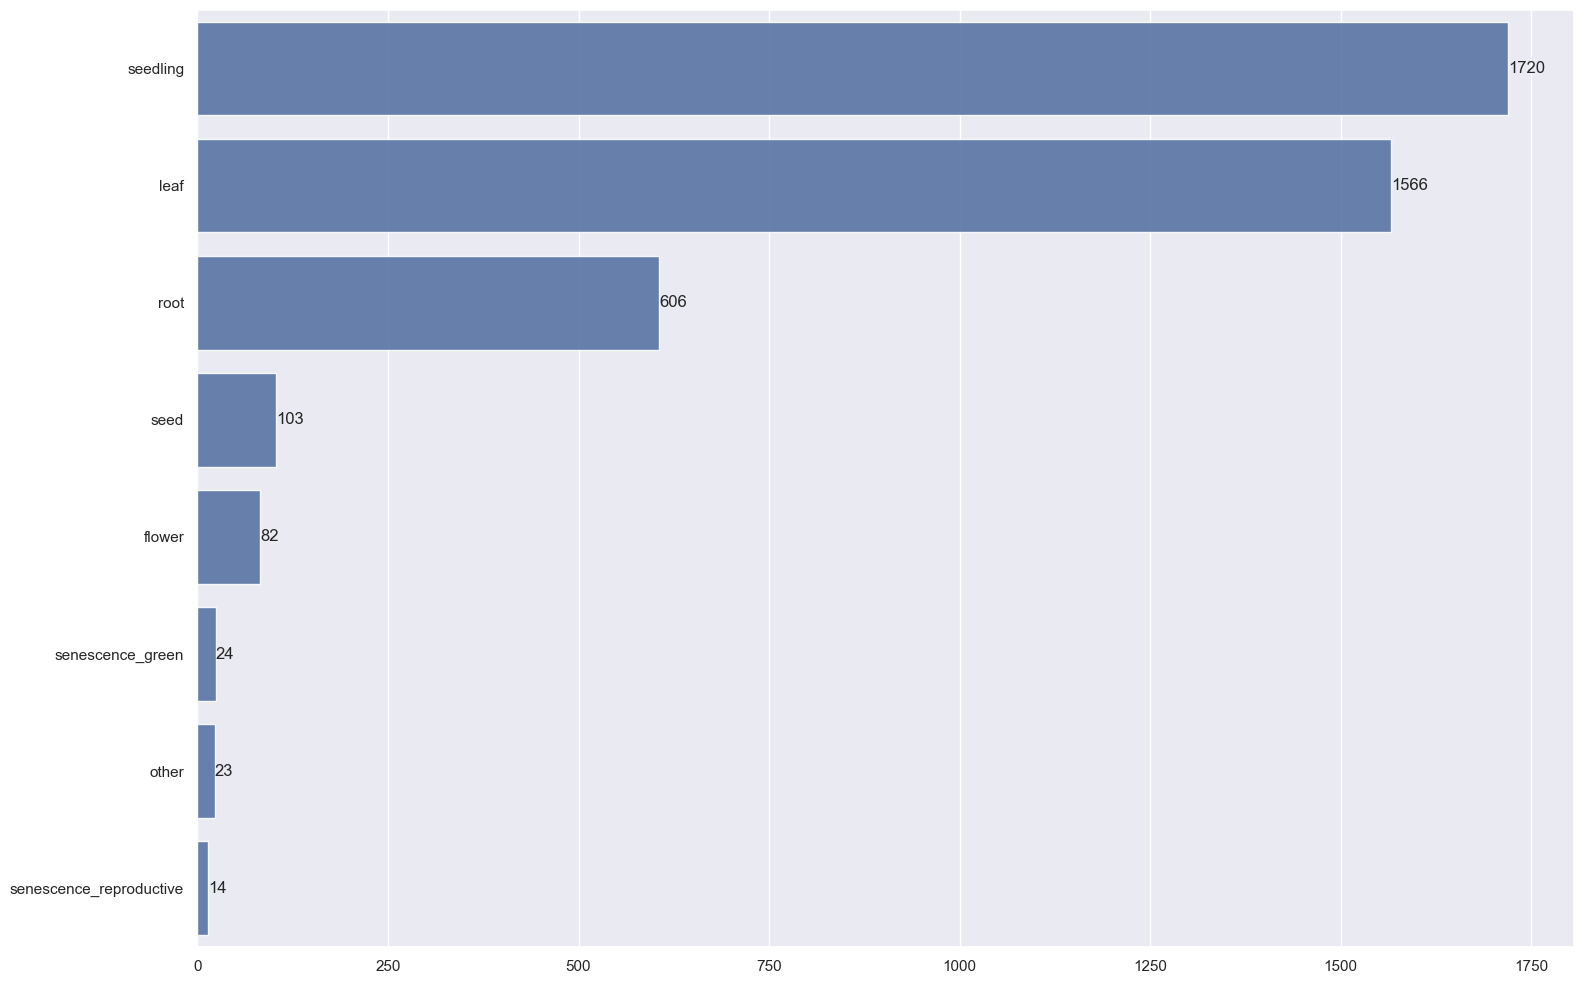

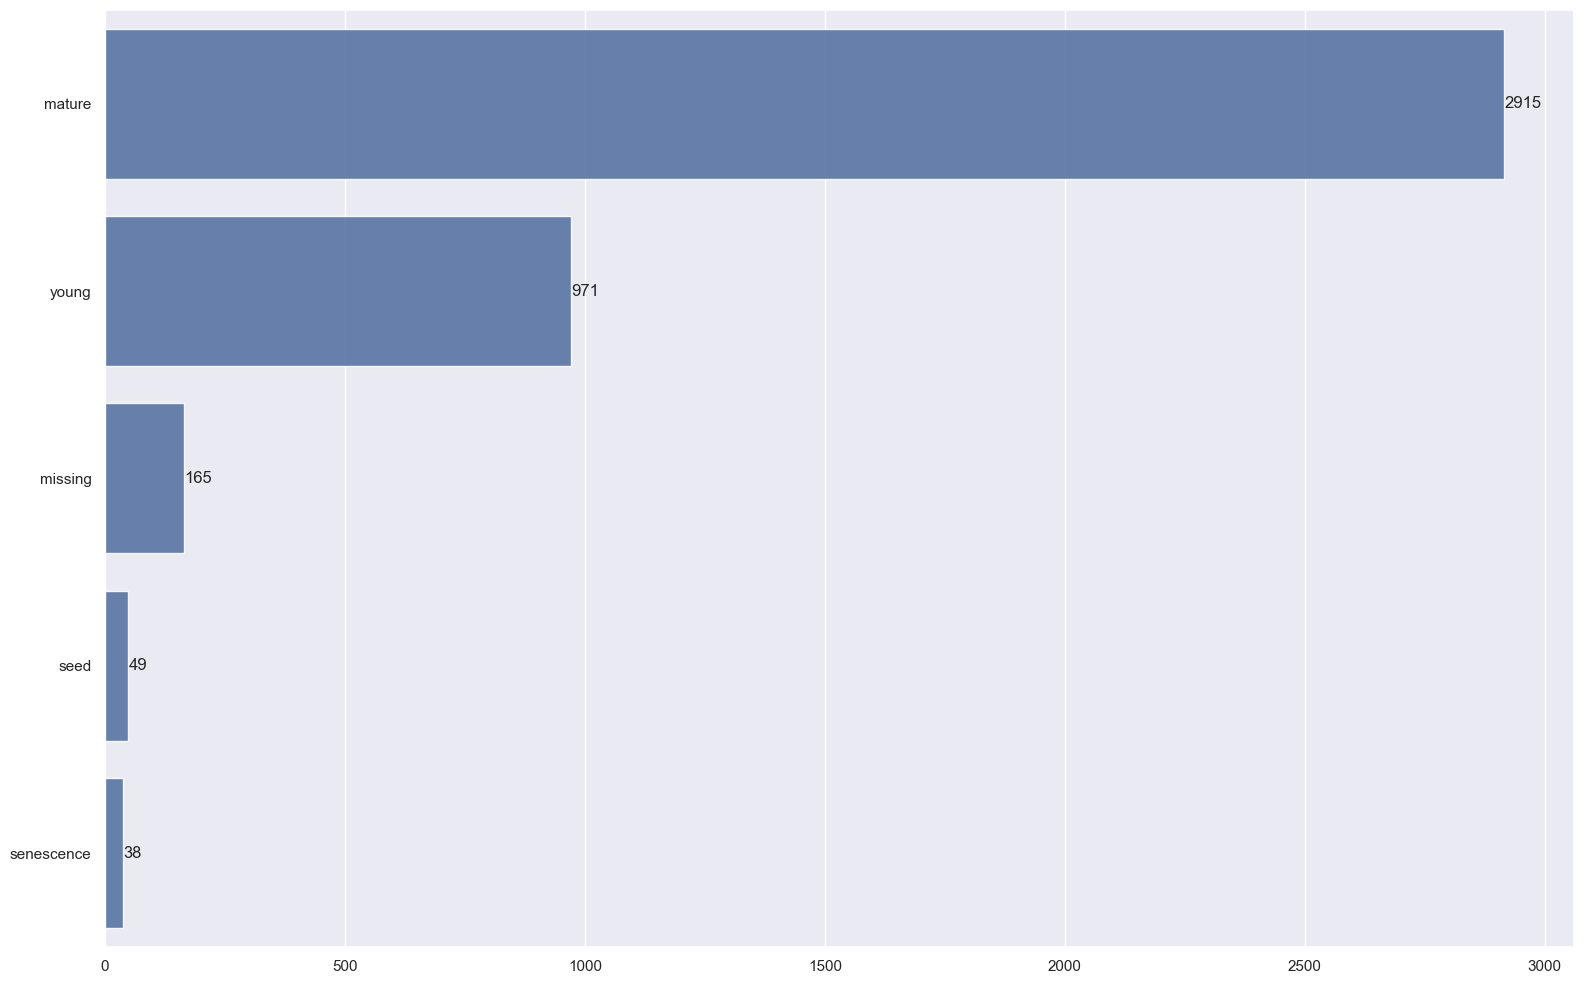

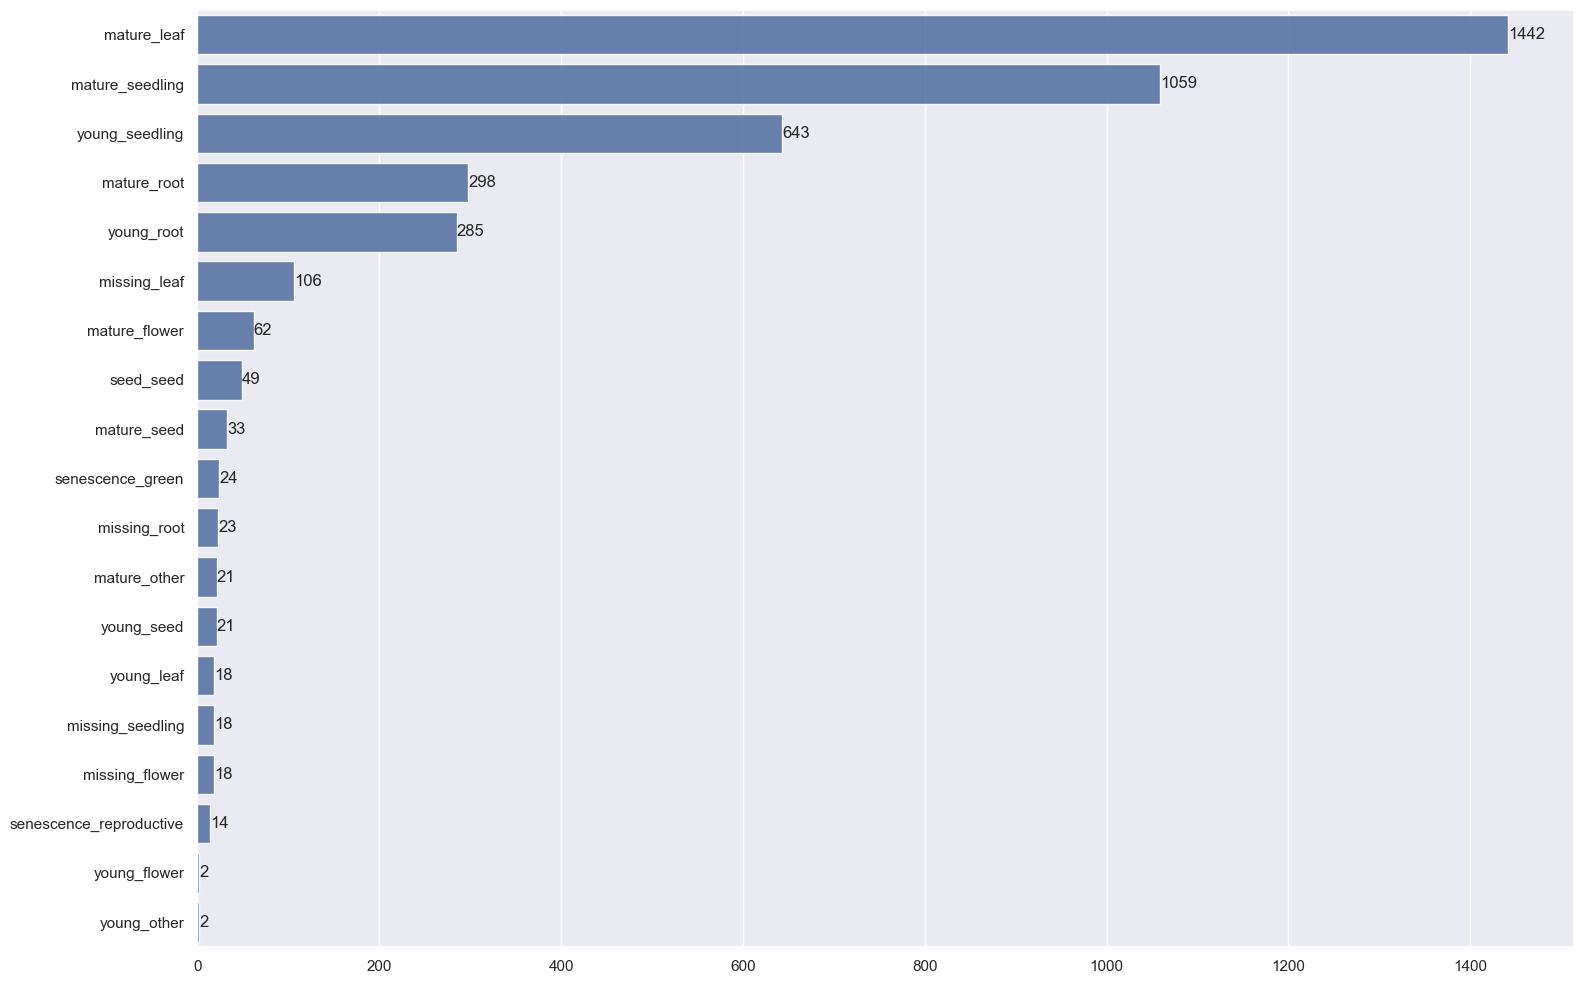

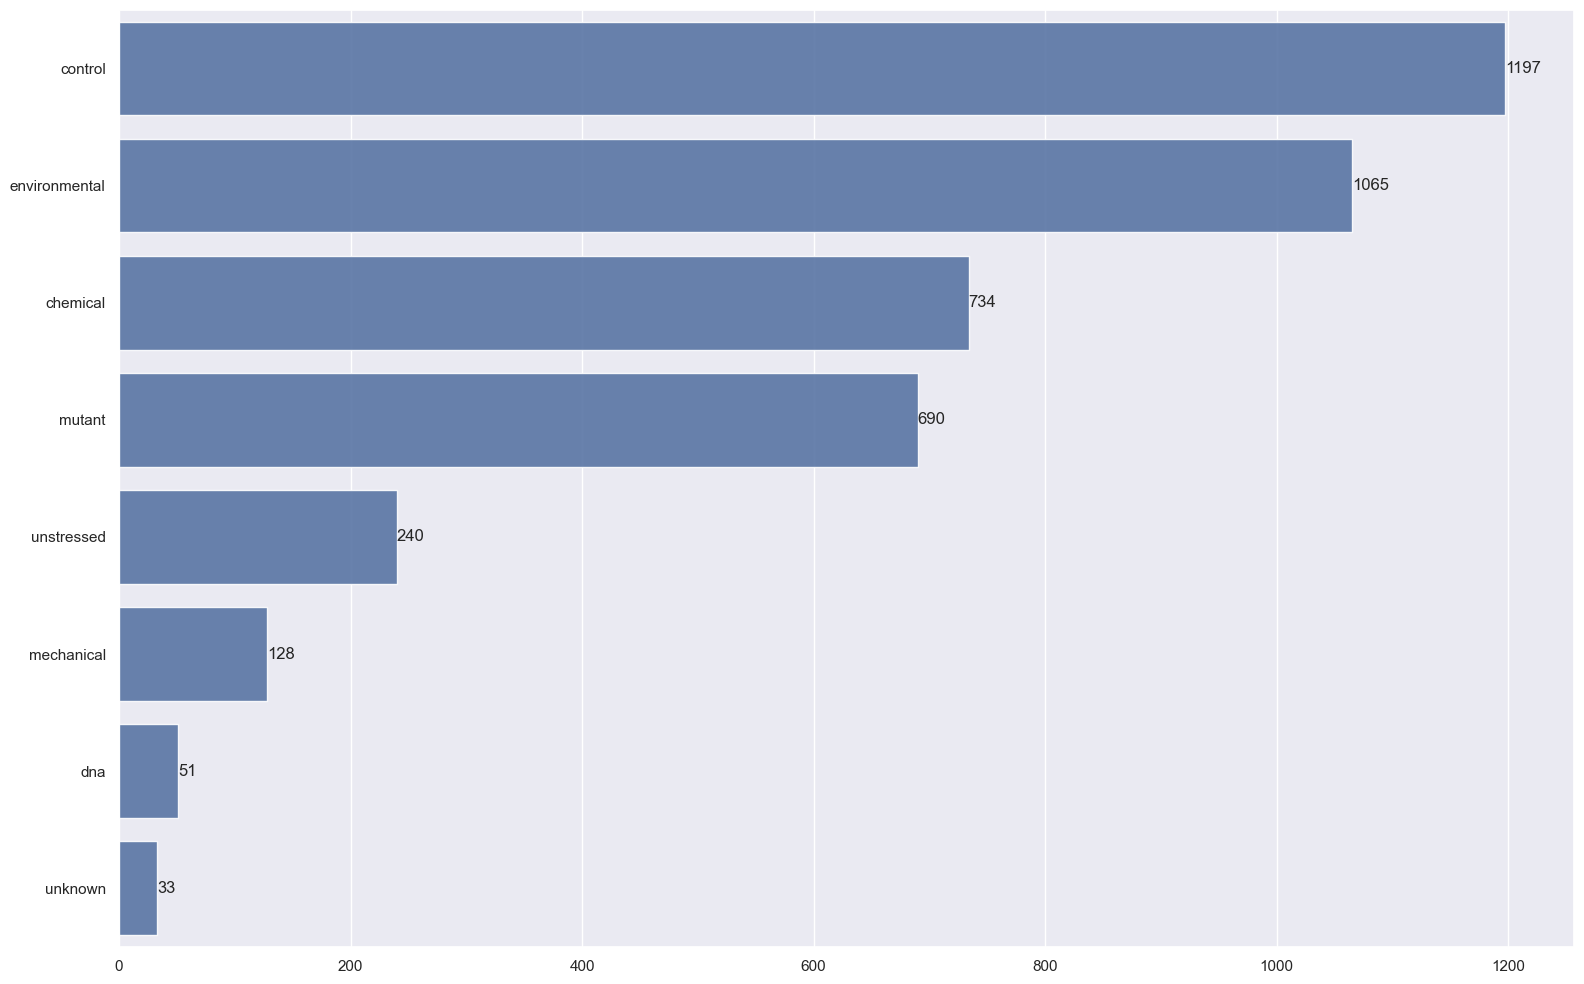

In [39]:
# Display the distribution of groups for all samples

data_metadata.distribution_barplot(
	data     = tissue_metadata,
	group    = 'Tissue',
	filename = os.path.join(OUT_PLOT, 'distribution-tissue')
)

data_metadata.distribution_barplot(
	data     = tissue_metadata,
	group    = 'Age',
	filename = os.path.join(OUT_PLOT, 'distribution-age')
)

data_metadata.distribution_barplot(
	data     = tissue_metadata,
	group    = 'Group',
	filename = os.path.join(OUT_PLOT, 'distribution-group')
)

data_metadata.distribution_barplot(
	data     = tissue_metadata,
	group    = 'Perturbation',
	filename = os.path.join(OUT_PLOT, 'distribution-perturbation')
)

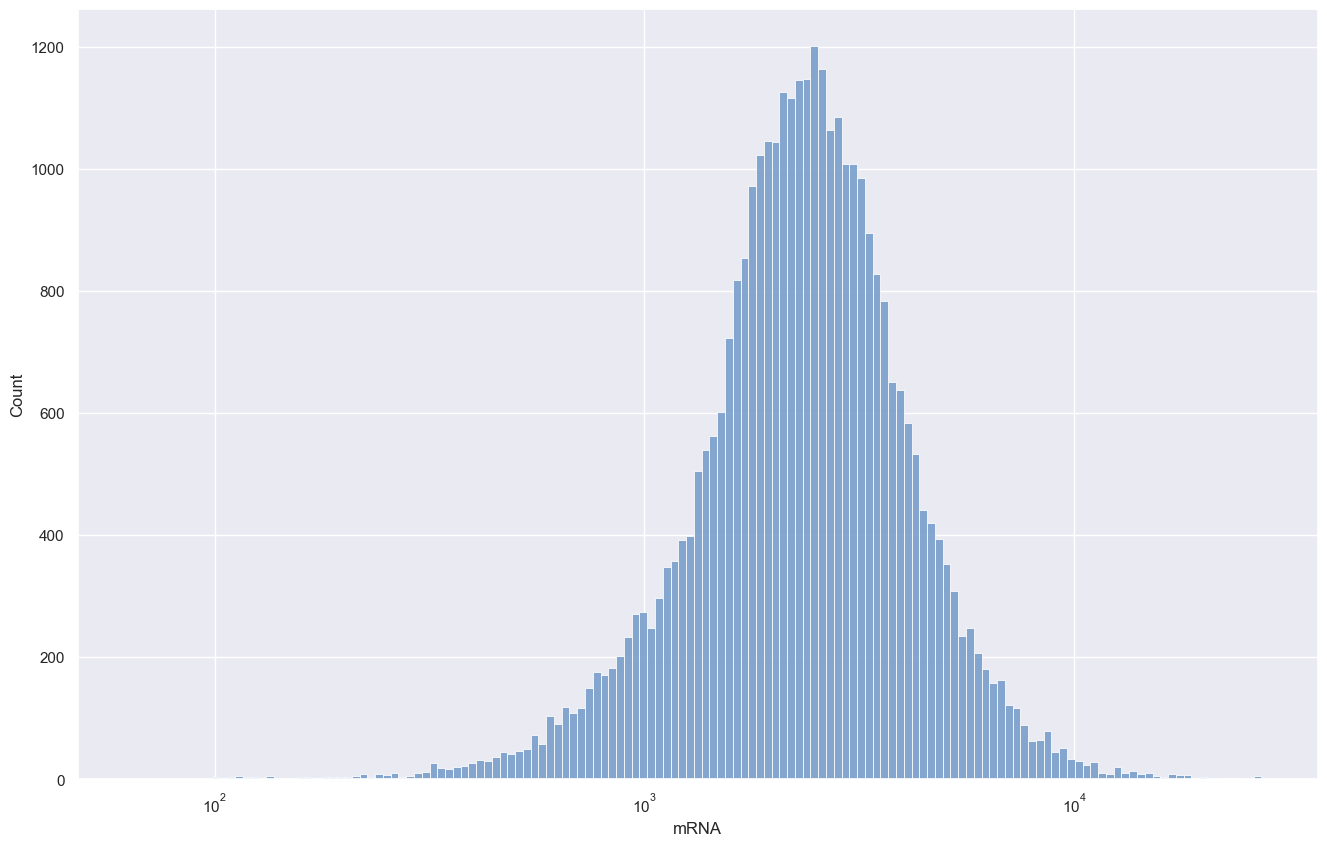

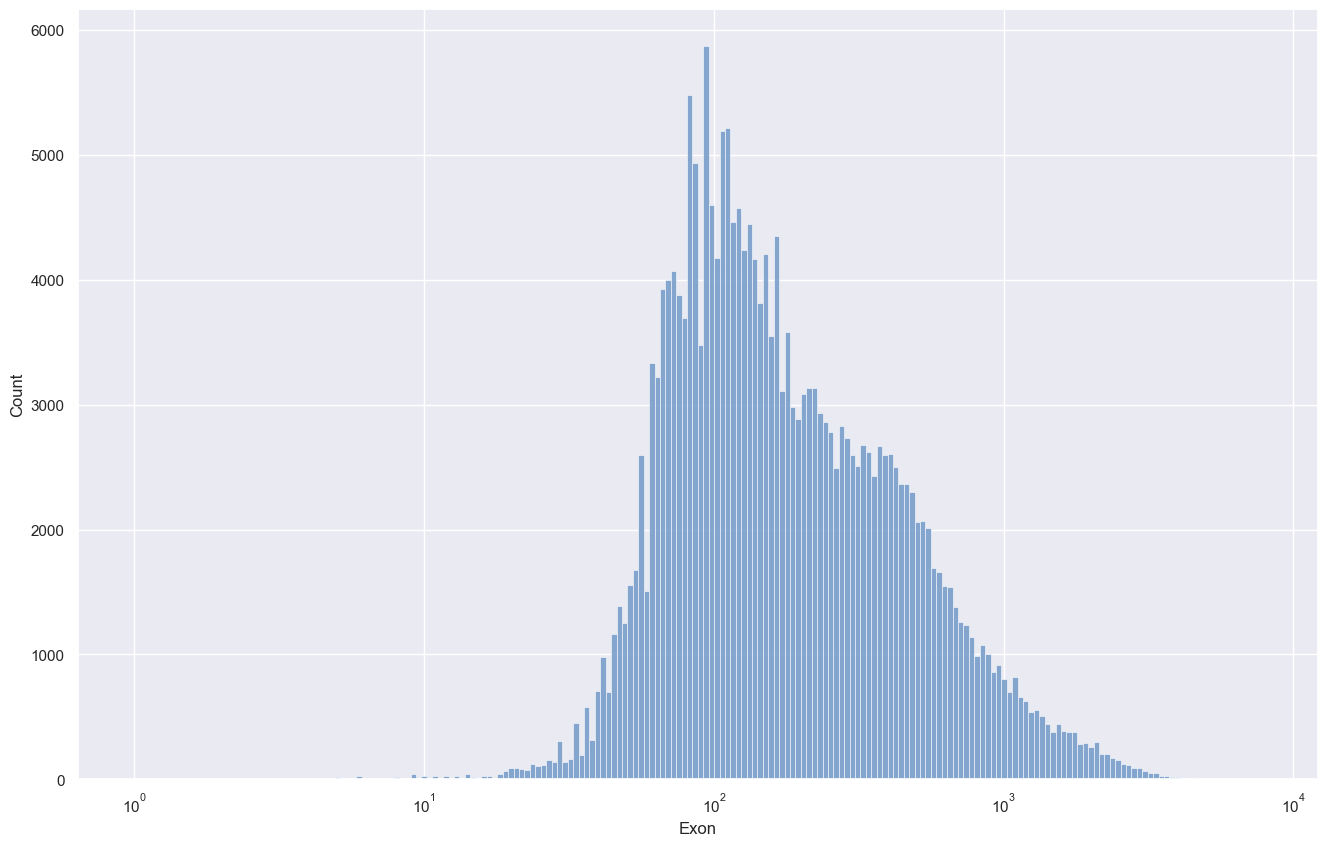

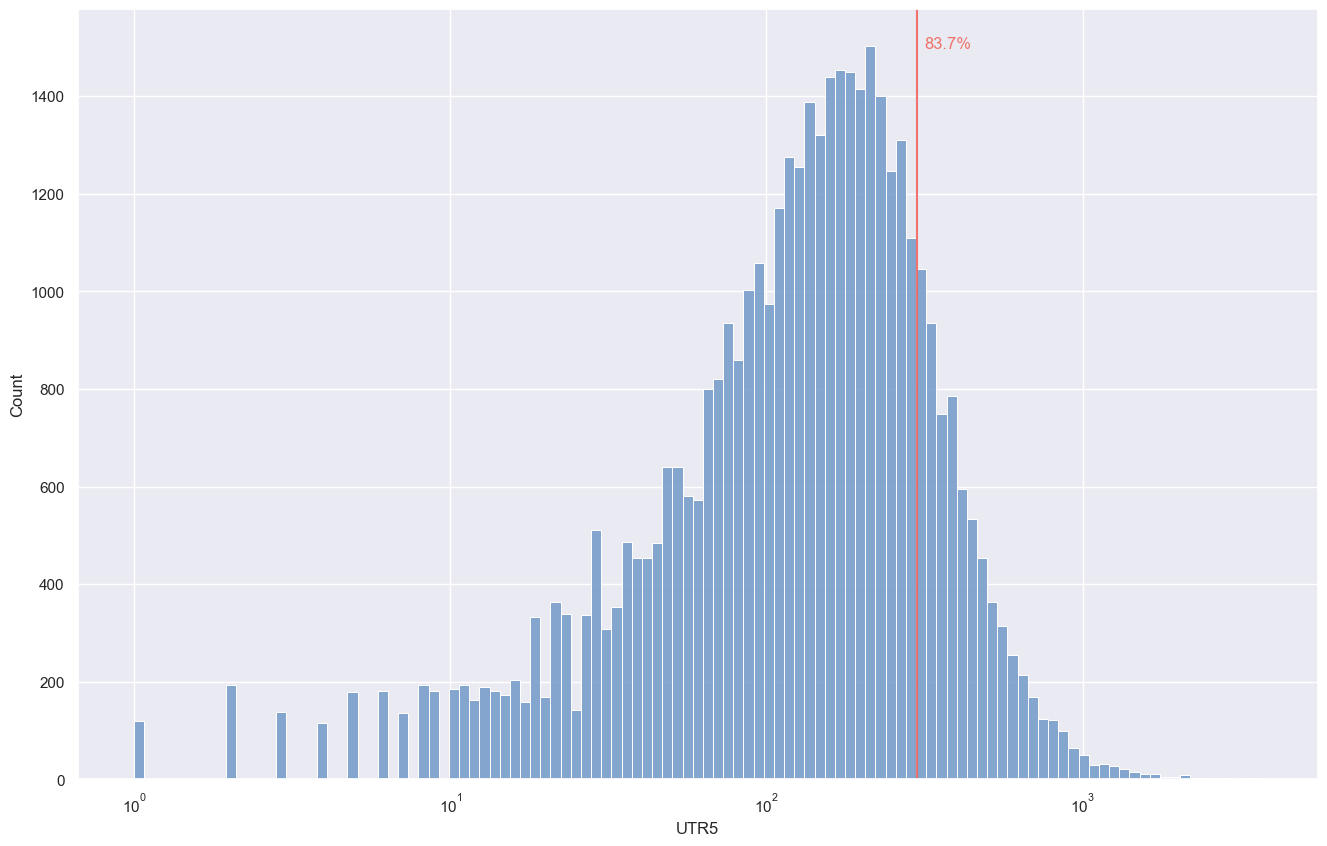

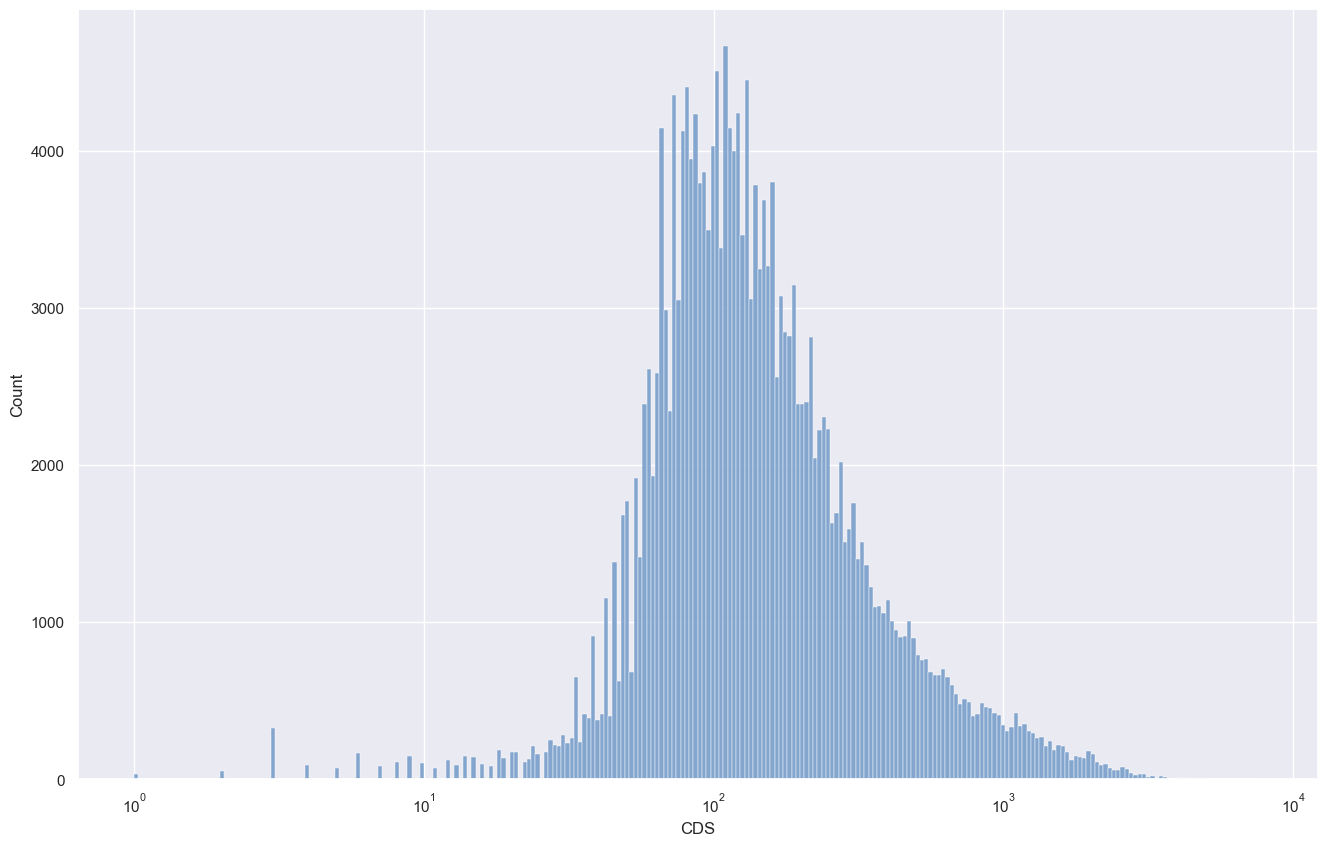

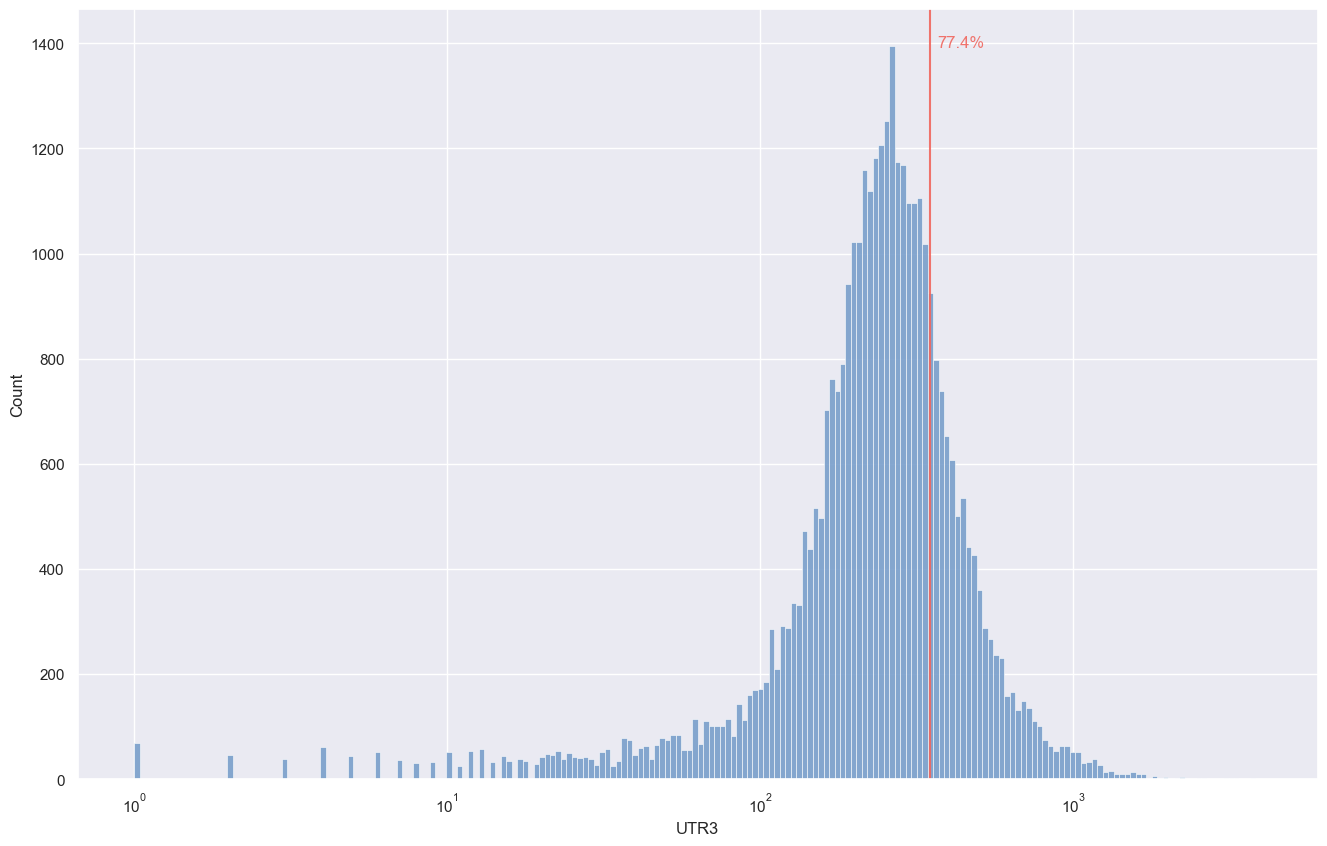

In [40]:
# Display the region length distributions per each region

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	data_annotation.length_histplot(
		data     = gene_annotation,
		value    = 'mRNA',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-region-mrna')
	)

	data_annotation.length_histplot(
		data     = gene_annotation,
		value    = 'Exon',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-region-exon')
	)

	data_annotation.length_histplot(
		data     = gene_annotation,
		value    = 'UTR5',
		vline    = 300,
		filename = os.path.join(OUT_PLOT, 'length-region-utr5')
	)

	data_annotation.length_histplot(
		data     = gene_annotation,
		value    = 'CDS',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-region-cds')
	)

	data_annotation.length_histplot(
		data     = gene_annotation,
		value    = 'UTR3',
		vline    = 350,
		filename = os.path.join(OUT_PLOT, 'length-region-utr3')
	)

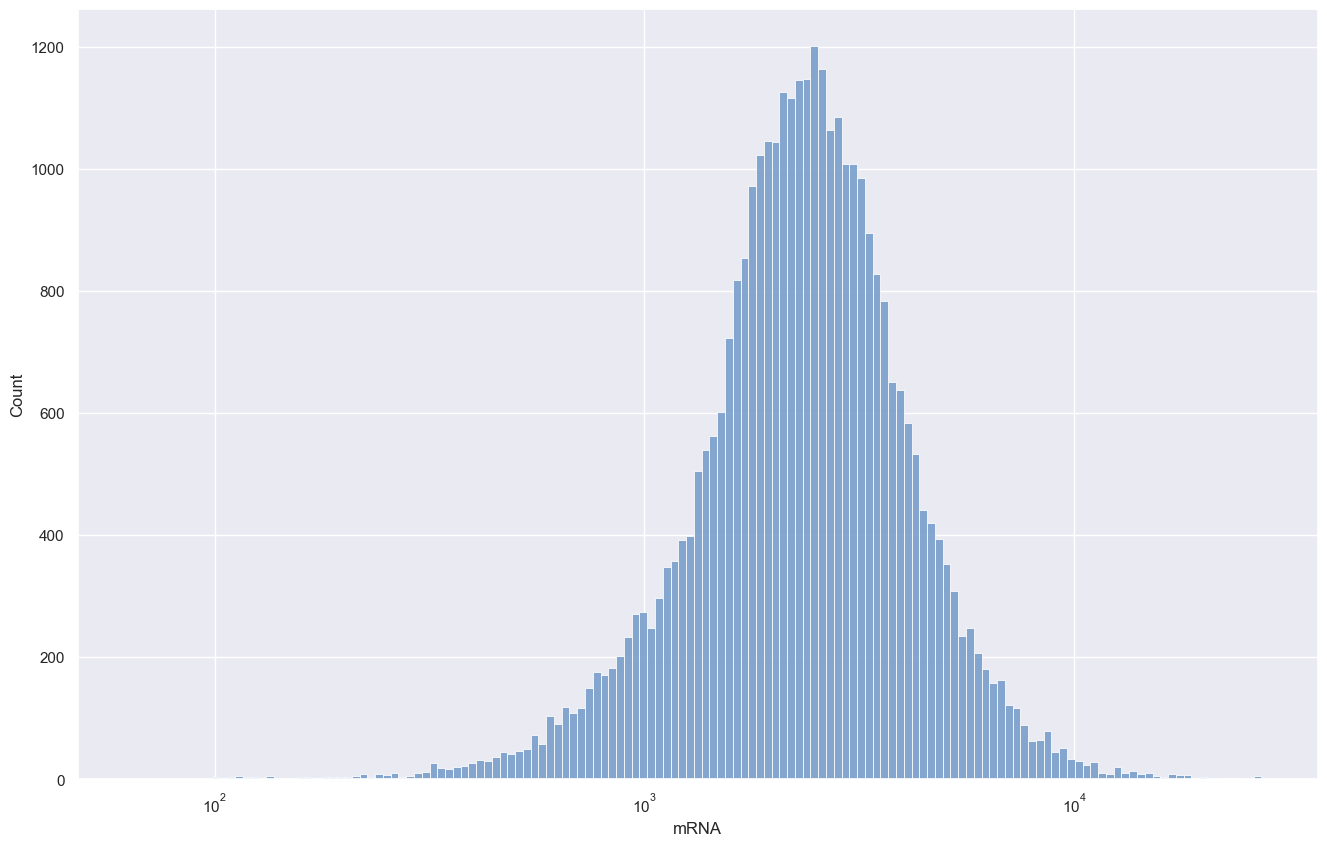

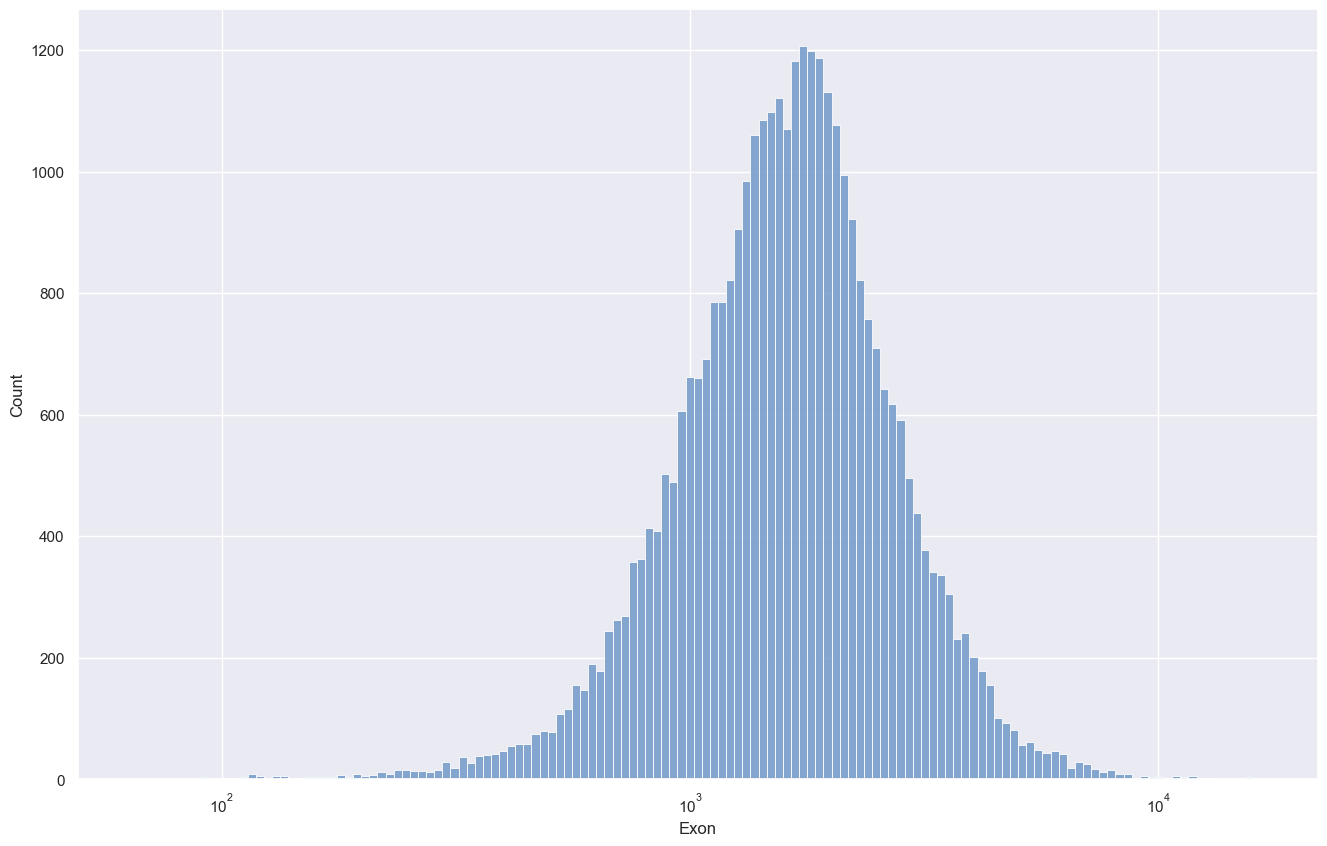

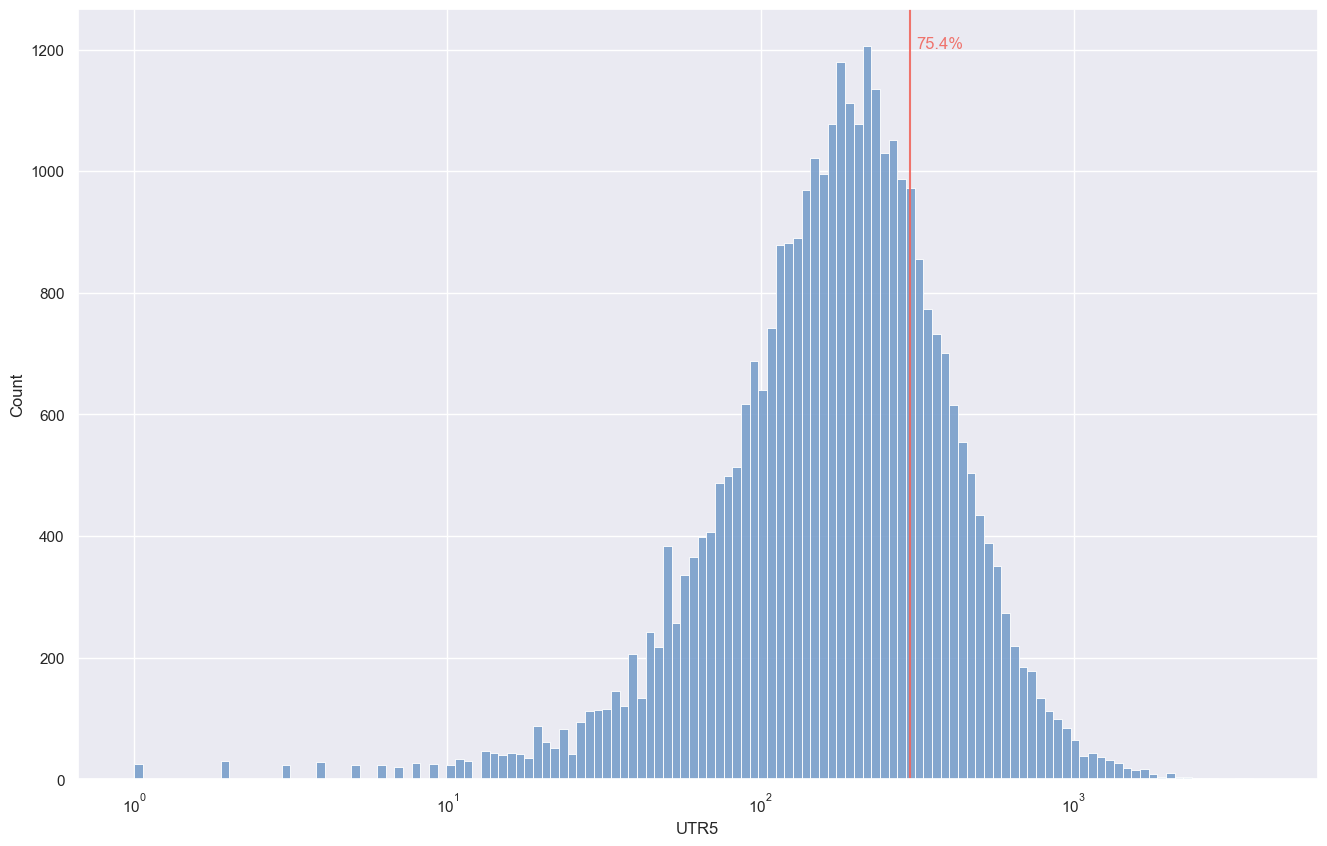

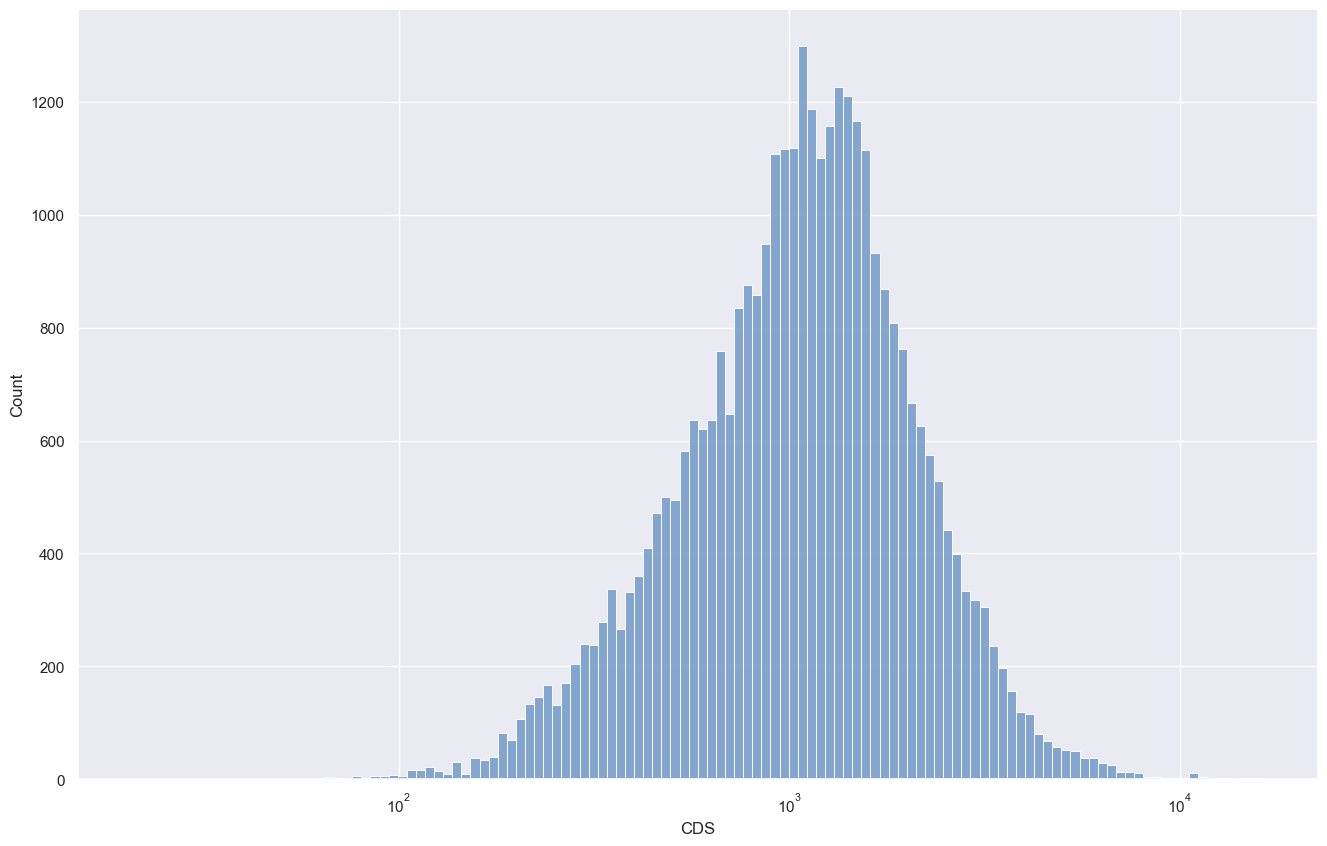

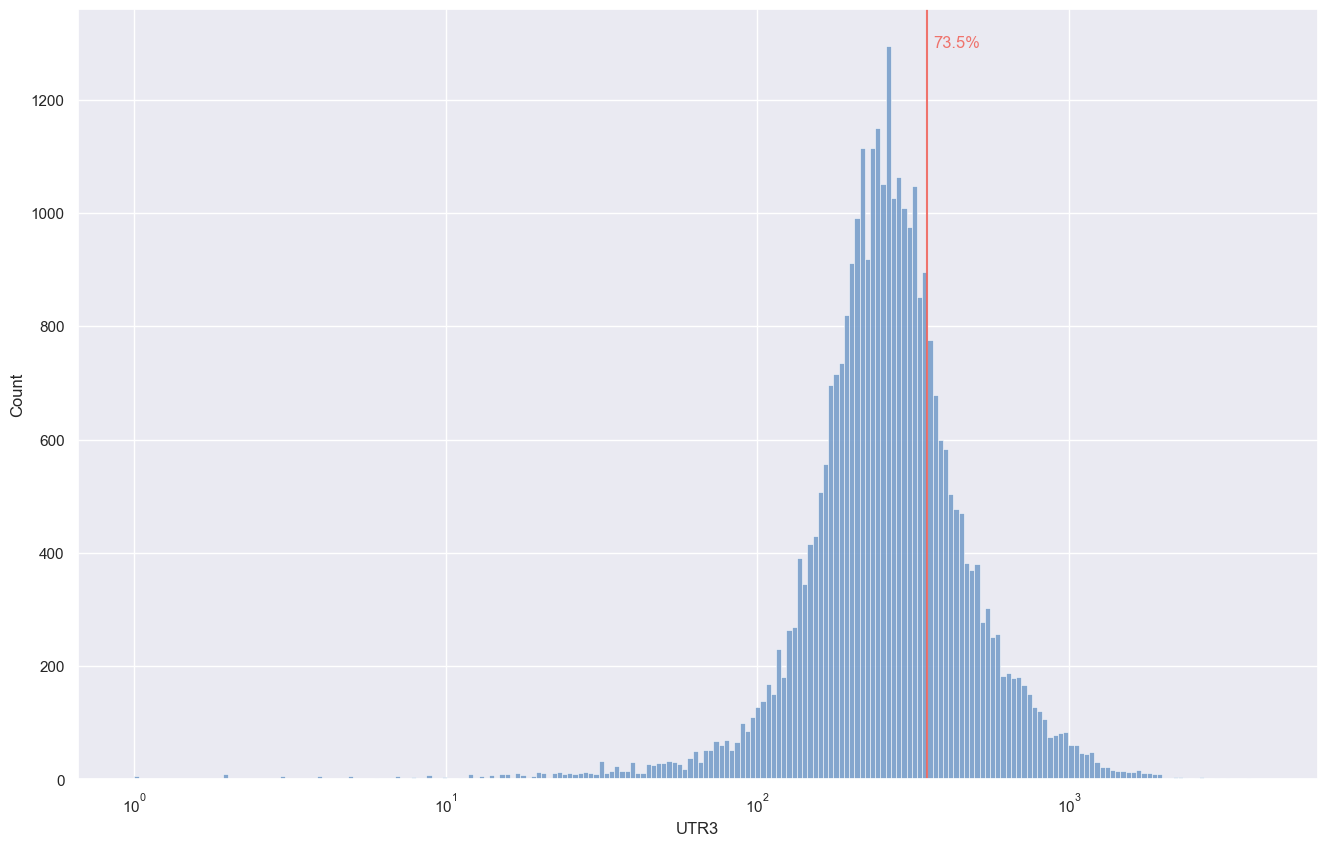

In [41]:
# Display the region length distributions per each region (grouped regions)

dataframe = data_annotation.group_regions(
	data    = gene_annotation,
	groupby = 'mRNA',
	regions = ['mRNA', 'Exon', 'UTR5', 'CDS', 'UTR3']
)

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	data_annotation.length_histplot(
		data     = dataframe,
		value    = 'mRNA',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-gene-mrna')
	)

	data_annotation.length_histplot(
		data     = dataframe,
		value    = 'Exon',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-gene-exon')
	)

	data_annotation.length_histplot(
		data     = dataframe,
		value    = 'UTR5',
		vline    = 300,
		filename = os.path.join(OUT_PLOT, 'length-gene-utr5')
	)

	data_annotation.length_histplot(
		data     = dataframe,
		value    = 'CDS',
		vline    = 0,
		filename = os.path.join(OUT_PLOT, 'length-gene-cds')
	)

	data_annotation.length_histplot(
		data     = dataframe,
		value    = 'UTR3',
		vline    = 350,
		filename = os.path.join(OUT_PLOT, 'length-gene-utr3')
	)